In [2]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'

Observation space Box(0.0, 4.0, (1,), float64)
Wrapping in observe setpoint error


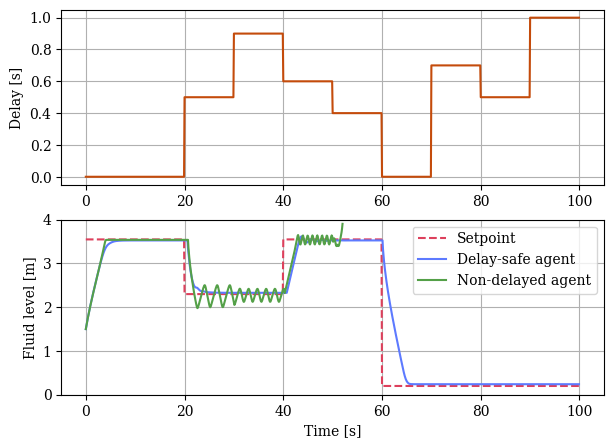

In [30]:

core_env = SphericalTank(desired_state=np.array([3.55, 2.3, 0.2]), max_episode_len=1000, seed = 2, start_state=np.array([1.5]))
core_env = init_wrappers(core_env, observation_type='setpoint-error')
env = VariableActionDelay(core_env, max_delay=10, init_delay=0, update_freq=100, delay_type='external')
safe_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\wcsac.zip')
tank_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\sac.zip')

env = AugmentState(env, known_delay=global_config.MAX_DELAY)

states, actions, rewards, avg_rewards, executed = test_augmented_agent(safe_agent, env, deterministic=True, state_error=True)
# plot_test(env, states, rewards, actions, executed )
# safe_agent = 

# obs, info = env.reset(), False
# terminated = truncated = False

# delays = []
# observations = []

# while not terminated and not truncated:
#     action = env.action_space.sample()
#     obs, reward, terminated, truncated, info = env.step(action)
#     delays.append(env.current_delay)
f, ax =plt.subplots(2,1, figsize=(7,5))

time_seconds = np.arange(0, len(states)/10, 0.1)

ax[0].plot(time_seconds, np.array(env.ep_delay_history)/10, global_config.COLORS['dark_orange'])
ax[1].plot(time_seconds, core_env.desired_trajectory, global_config.COLORS['cold_red'] , linestyle = '--')
ax[1].plot(time_seconds, states, global_config.COLORS['warm_blue'])
states, actions, rewards, avg_rewards, executed = test_delayed_agent(tank_agent, env, deterministic=True, state_error=True, known_delay=0, env_model = copy.deepcopy(core_env))
time_seconds = np.arange(0, len(states)/10, 0.1)
ax[1].plot(time_seconds, states, global_config.COLORS['mid_green'])
# ax[0].set_xticks(range(0,120,20))
ax[0].set_ylabel(r'Delay [s]')
# ax[0].legend(['Delay'], loc='upper right')
# ax[1].legend(['Desired level', 'Non-delayed agent'], loc='upper right')
# ax[1].legend(['Desired level', 'Delay-safe agent'], loc='upper right')

ax[1].legend(['Setpoint', 'Delay-safe agent', 'Non-delayed agent'], loc='upper right')
ax[1].set_ylabel(r'Fluid level [m]')
ax[1].set_xlabel(r'Time [s]')
ax[1].set_ylim([0, 4])
ax[0].grid()
ax[1].grid()
# plt.legend(['Delay', 'Setpoint', 'State'])


# plot_test(env, states, rewards, actions, executed )

# plt.plot(env.ep_delay_history, 'b')
# plt.plot(core_env.desired_trajectory, 'r--')



### Plot training

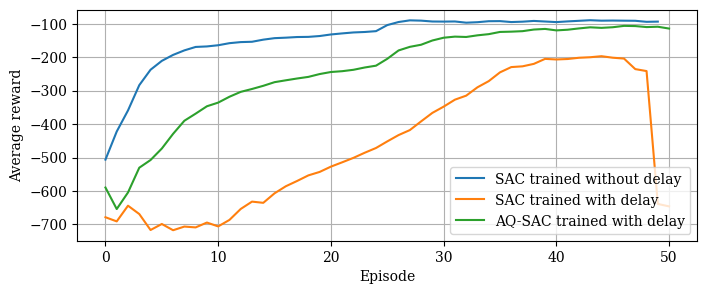

In [19]:
safedf = pd.read_csv('logs\\train\\SphericalTank\\setpoint-error\\randomised\\0524\\Desired3.0\\wcsac\\progress.csv')
optimaldf = pd.read_csv('logs\\train\\SphericalTank\\setpoint-error\\randomised\\0524\\Desired3.0\\sac\\progress.csv')
undelayeddf = pd.read_csv('logs\\train\\SphericalTank\\setpoint-error\\randomised\\0531\\Desired3.105\\sac\\progress.csv')
plt.figure(figsize=(8,3))
plt.plot(optimaldf['rollout/ep_rew_mean'])
plt.plot(undelayeddf['rollout/ep_rew_mean'])
plt.plot(safedf['rollout/ep_rew_mean'])
plt.grid()
plt.legend(['SAC trained without delay', 'SAC trained with delay', 'AQ-SAC trained with delay'], loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()


